In [76]:
import numpy as np
import random
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
from typing import List
from tqdm import tqdm

from IPython.core.debugger import set_trace

# Continuous blackjack

Consider a simple mathematical formulation of blackjack game. Instead of cards we will let each player draw from continuous uniform distribution between 0 and 1. Players play in some order. During their turn they play using two actions: 
* hit
* pass

Hit means they take one more number and add it to their current score. Each player plays until they either pass or their score exceeds 1.
The goal is to get closest to 1 without exceeding one.

In [28]:
n_players = 5

def hit() -> float:
    return random.random()

## Simple strategy
Let's try to implement this game and think about the strategy each player can take. Function `play_hand` will be responsible for a strategy of each player. Player knows how many players there are and what scores previous players have.

Because of that, we can immedietaly see the most obvoius strategy: we cannot win if there is some player with a score below 1 that is higher than ours. Let's than beat every player that came before us - we have to do it in order to win.

In [29]:
def play_hand(previous_hands: List[float], n_players: int) -> float:
    n = len(previous_hands) + 1
    n_players_left = n_players - n
    score = hit()
    max_score = np.max([hand for hand in previous_hands if hand < 1], initial=0)
    while score < max_score < 1:
        score += hit()
    return score

This strategy is not at all bad. This is simply something we have to do. But let's think if there is something we can improve.

## Last player strategy - probability of winning
For sure, if we come last, there is nothing else we can do: we just want to beat every other player and we don't risk anything if we have a score lower than current best player. So the strategy for the last player is the strategy we implemented in the previous function. In other words: it is deterministic and obvious for every player.

We can now stop and wonder: what is the chance of the last player to win, given some max_score of previous players. It is not that obvious. For example let's consider max score of 0.9. Last player can draw 0.91 in it's first hit. There is 0.1 chance that he will win in the first try. But if he doesn't he can keep playing. But now there is some chance that he will lose (depending on the value of first hit).

We can evaluate this probability (approximately) using simulation.

In [16]:
plays = [play_hand([0.9, 0.9, 0.9, 0.9], 5) for _ in range(100_000)]
np.mean([play < 1 for play in plays])

0.24464

This is interesting, but can we evaluate it analytically?

Yes.

**Warning**: This is completely useless mathematics.

Let $(X_i)$ be a sequence of independent uniform random variables. Also, let $N$ be the smallest integer, such that $\sum_{i=1}^N X_i> 0.9$ (that definition implies that $N$ is random variable as well - dependent in some way on $X_i$s).

We want to evaluate $\mathbb{P} ( 1 > \sum_{i=1}^N X_i> 0.9)$. We see that if we now value of the first throw the problem is similar. $\mathbb{P} ( 1 > \sum_{i=1}^N X_i> 0.9 | X_1) = \mathbb{P} ( 1 - X_1 > \sum_{i=2}^N X_i> 0.9 - X_1 | X_1)$. This is exactly the same thing, except that:
* we condition on $X_1$
* the boundary values change a little bit

Based on that observation, let's denote (for $y < 0.9$) $$p(y) = \mathbb{P} ( 1 - y > \sum_{i=1}^N X_i> 0.9 - y)$$

Since we know a little bit of probability theory, we know that $$p(y) = \mathbb{P} ( 1 - y > \sum_{i=1}^N X_i> 0.9 - y) = \mathbb{E}[ \mathbb{P} ( 1 - y - X_1 > \sum_{i=2}^N X_i> 0.9 - y - X_1 | X_1)]$$.

Because $X_1$ is a continuous uniform distribution we obtain: 
$$p(y) = \int_0^{0.9 - y} p(y + x_1) dx_1 + \mathbb{P}(0.9 - y < X_1 < 1 - y) = \int_y^{0.9} p(t) dt + 0.1$$.

This is an integral equation. We can differentiate both sides, use the fundamental theorem of calculus and solve for differential equation $p'(y) = -p(y)$, knowing that $p(0.9) = 0.1$ (we know this condition both from the integral equation and from the fact that if the best score is $0.9$ and we have a score of exactly 0.9, we have to beat it and there is only $10\%$ chance we won't exceed $1$). We obtain $p(y) = 0.1 e^{0.9} e^{-t}$. Finally, since we are interested in the case when $y = 0$ we get $p(0) = 0.1 e^{0.9}$. In general (for different max_scores m), we have:
$$ p = (1 - m) e^{m}$$


In [17]:
np.exp(0.9)*0.1  # Exact probability of last player winning.

0.245960311115695

In [9]:
def prob_last_wins(max_score):
    return (1 - max_score) * np.exp(max_score)

Text(0.5, 1.0, 'Probability of last player winning')

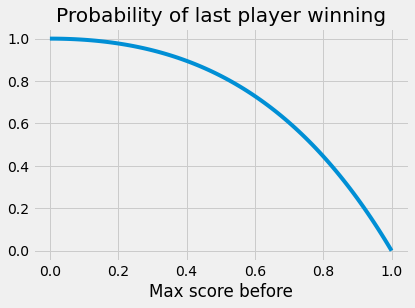

In [10]:
x = np.linspace(0, 1, 100)
y = np.array([prob_last_wins(p) for p in x])
plt.plot(x, y)
plt.xlabel("Max score before")
plt.title("Probability of last player winning")

In [11]:
x[np.argmin([np.abs(prob_last_wins(p) - 0.5) for p in x])]

0.7676767676767677

## So, what second last player should do?
Let's say we are now a player that comes directly before the last one. What should we do? Well, first of all, we should beat all previous players. BUT, after we do that (assuming we don't go bust), we know what last player will do. We know exactly (based on a curve plotted above) what is the probability of the last player winning at this point. In particular, if our score is below $0.76$, we know that last players wins with probability above $0.5$. Initially I thought that this means that we should hit if we are below $0.76$. This doesn't make sense however, the last player always has the advantage. The space of outcomes is divided on three (not two) cases: last player wins, we win and some player before us wins (if we go bust). The risk of us going bust if we already have over $0.7$ and exceeded all of the previous players is to big.

Our goal is to find a threshold below which we always hit when we are second to last. We will try to evaluate multiple strategies for doing that for various thresholds and see what's best.

In [168]:
def probability_of_win_second(threshold: float, *, n_plays=10_000):
    n_wins = 0
    for _ in range(n_plays):
        score = 0
        while score < threshold:
            score += hit()
        if score > 1:
            continue
        else:
            competing_score = 0  
            # Last player executes his simple strategy
            while competing_score < score:
                competing_score += hit()
            # If he beat us we lose otherwise we win
            if competing_score < score or competing_score > 1:
                n_wins += 1
    return n_wins / n_plays

In [170]:
thresholds = np.linspace(1e-3, 1, 1_000)  # for threshold of 0 we cannot ever win
probabilities = [probability_of_win_second(t, n_plays=10_000) for t in thresholds]
best_threshold = thresholds[np.argmax(probabilities)]
best_threshold, probability_of_win_second(best_threshold)

(0.5640000000000001, 0.4331)

In [260]:
def plot_probabilities(x, y, best_threshold, title):
    plt.plot(x, y)
    plt.axvline(best_threshold, color="red", linestyle="--", linewidth=2, label=f"threshold = {best_threshold:.2f}")
    plt.xlabel("threshold")
    plt.ylabel("probability of win")
    plt.legend()
    plt.title(title);

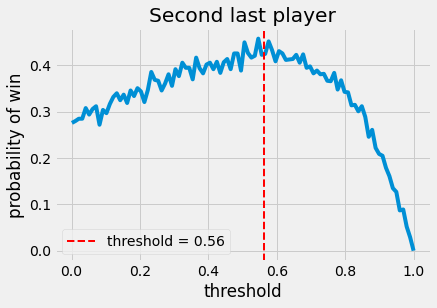

In [261]:
plot_probabilities(thresholds, probabilities, best_threshold, "Second last player")

We essentialy made a simulation of scenarios for various thresholds and saw that the best threshold is around $0.58$ and gives you $0.42$ probability of winning, but we clearly see some variance in the results (even for a large sample which takes over a minute to compute). Is there an analytical solution for this?

I don't know. It would be easier if for example I came up with a distrubution of $S(t)$ - the score with a strategy to exceed threshold $t$ or at least had a way to calculate it's expected value. We essentialy have to compute a probability that we get a value smaller than $1$ playing this strategy and the person after us won't beat us. We can condition on the value we get, but we don't know a distribution of these values (except that these values are between $t$ and $1$).

Let's continue with simulation for more players.

In [173]:
def probability_of_win_third(threshold: float, *, n_plays=10_000):
    n_wins = 0
    for _ in range(n_plays):
        score = 0
        while score < threshold:
            score += hit()
        if score > 1:
            continue
        else:
            second_score = 0  
            # Second last player executes his strategy
            while second_score < score or second_score < best_threshold:
                second_score += hit()
            last_score = 0
            # Last player executes his strategy
            while last_score < score or last_score < second_score < 1:
                last_score += hit()
            if (score > second_score or second_score > 1) and (score > last_score or last_score > 1):
                n_wins += 1
    return n_wins / n_plays

In [188]:
thresholds = np.linspace(1e-3, 1, 1_000)  # for threshold of 0 we cannot ever win
third_probabilities = [probability_of_win_third(t, n_plays=1_000) for t in thresholds]
third_threshold = thresholds[np.argmax(third_probabilities)]
third_threshold, probability_of_win_third(third_threshold)

(0.754, 0.2803)

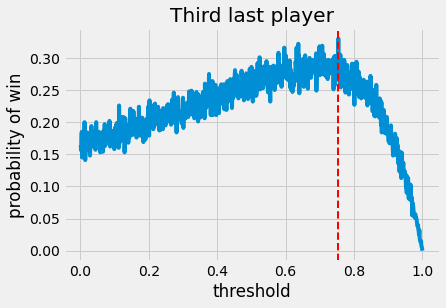

In [189]:
plot_probabilities(thresholds, third_probabilities, third_threshold, "Third last player")

This shows, that the third player should be a little bit more aggresive, he has less to lose and should hit until he exceeds $0.69$. Let's compute thresholds for more players.

In [227]:
def get_probability_of_win(threshold: float, next_thresholds: List[float], *, n_plays=1_000):
    """@next_thresholds: List[float]: List of thresholds of next players, including 0 for last player."""
    assert next_thresholds[-1] == 0.
    n_wins = 0
    scores = []
    for _ in range(n_plays):
        score = 0
        lost = False
        # Play according to the strategy
        while score < threshold:
            score += hit()
        if score > 1:
            continue
        # we do simulation until someone settles for a score better than ours
        for current_threshold in next_thresholds:
            current_score = 0
            while current_score < current_threshold or current_score < score:
                current_score += hit()
            if score < current_score < 1:
                lost = True
                break  # no point to continue simulation, we already lost
        if not lost:
            n_wins += 1  # if there was no score better than ours
    return n_wins / n_plays

In [228]:
get_probability_of_win(0.70, [0.58, 0])

0.299

In [246]:
def get_all_thresholds(n_players, *, n_plays=1_000, precision=2):
    thresholds = np.linspace(1e-3, 1, 10**precision)
    probabilities_list = []
    optimal_thresholds = [0]
    for player in tqdm(range(n_players)):
        probabilities = [get_probability_of_win(t, optimal_thresholds, n_plays=n_plays) for t in thresholds]
        probabilities_list.insert(0, probabilities)
        optimal = thresholds[np.argmax(probabilities)]
        optimal_thresholds.insert(0, optimal)
    return optimal_thresholds, (thresholds, probabilities_list)

In [268]:
n_players = 40
optimal_thresholds, (thresholds, probabilities_list) = get_all_thresholds(n_players, n_plays=100_000)


100%|██████████| 40/40 [25:40<00:00, 38.51s/it]


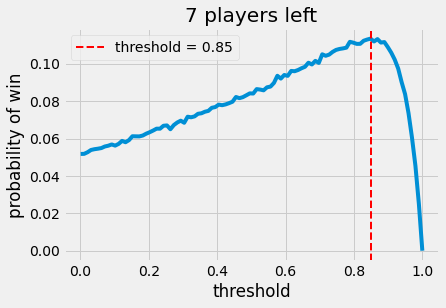

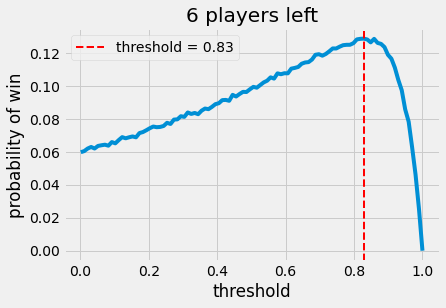

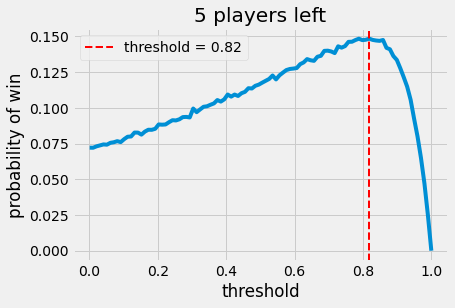

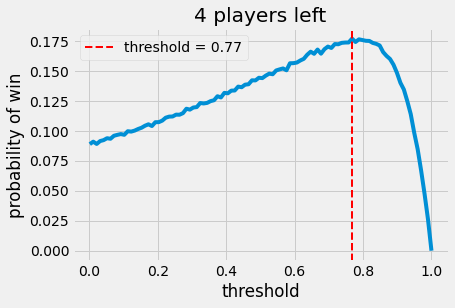

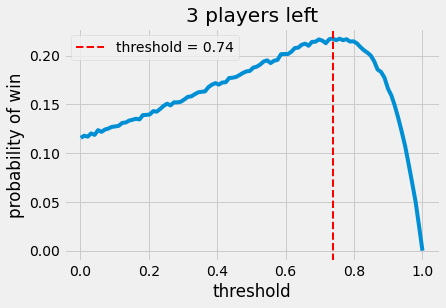

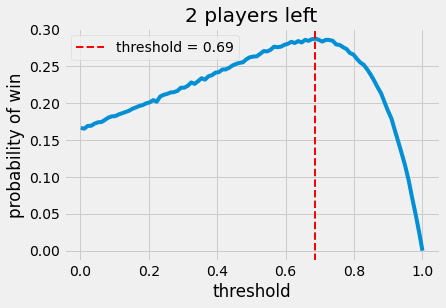

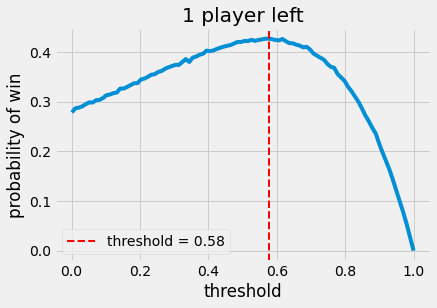

In [269]:
for i, probabilities in enumerate(probabilities_list):
    n_players_left = n_players - i
    if n_players_left < 8:
        word = "player" if n_players_left == 1 else "players"
        plot_probabilities(thresholds, probabilities, best_threshold=optimal_thresholds[i], title=f"{n_players_left} {word} left")
        plt.show()

Probabilities to the left are probabilities of us winning when using strategy with given threshold but *assuming* that we've already beat previous players (or that they all lost). If we didn't beat them, we obviously have to increase our threshold.

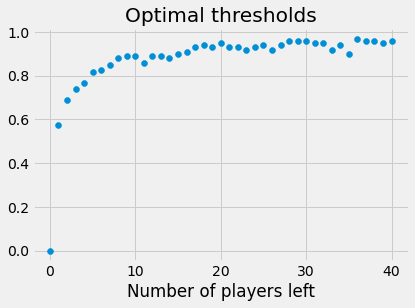

In [281]:
x = list(range(n_players + 1))
y = list(reversed(optimal_thresholds))
plt.scatter(x, y)
plt.xlabel("Number of players left")
plt.title("Optimal thresholds");

We obtained a full strategy for this game by observing that starting from the last player, each preceding player can understand what the next will do. In terms of technical improvements, we could increase the number of simulated plays to decrease variance of our estimator. We could also think about coming up with an analytical solution, but I didn't know how to successfuly approach this problem.

One last remark: this strategy is optimal when each player is rational. But in reality this assumption not always holds. People can get greedy and risk hitting when it's not good for them. If multiple players after us risk a lot, they lose a lot more which essentialy lowers the effetive number of players after us. Because of that, it is possible that after observing such pattern, it would be possible to assess each players strategy and lower our threshold. In this way it could be possible to beat a bot that plays according to this "optimal" strategy. Reasoning about imperfect strategies is more difficult for mathematical analysis, but it's an interesting problem to think about.